## 问题描述

在每一个时间步$t$，一个决策制定者需要在给定一个观测变量$x_t$（例如疫情感染人数）的基础上预测一个标签$y_t$（例如对原始预测的修正offset），其中观测变量$x_t$来源于其他物理或动力学模型（例如疫情扩散模型SIR）

假设观测变量序列$X_t$原始服从相互独立的[0,1]均匀分布，实际观测变量与标签（$(x_t,y_t)$对）的函数关系为$h$，有$y_t=h(x_t)$，使用 SEW 策略去学习此函数$h$

假设时段数为$T=5000$，分别有三种函数$h$的形式：
* 三次函数，$h(x)=x^3$
* 阈值函数，$h(x)=\bold{1}[x>0.5]$
* 分段函数:$h(x)=\frac{2}{3}\cdot \bold{1}[x\in (0.25,0.5)] + \frac{1}{3}\cdot \bold{1}[x\in (0.5,0.75)]+ \bold{1}[x\in (0.75,1)]$


In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# 定义三种函数
def H1(x):
    return math.pow(x,3)

def H2(x):
    if x > 0.5:
        return 1
    else:
        return 0

def H3(x):
    if x >= 0.25 and x< 0.5:
        return 2/3
    elif x >= 0.5 and x < 0.75:
        return 1/3
    elif x >= 0.75 and x < 1:
        return 1
    else:
        return 0

def InitializeK(T):
     #依据论文定义
    return math.ceil(math.pow(T,1/3)/(4*math.pow(math.log(T+1),1/3)))

#向量化函数
def VectorizeFun(H):
    return np.vectorize(H)

In [44]:
#SEW Policy
def SEW(T,real_X,real_Y):
    # 初始化 K
    K = InitializeK(T)
    Ts = [t+1 for t in range(T)]
    # 生成实际的观测变量Xt与标签Yt
    history_x = []
    history_y = []
    Predict_Ys = []
    for t_index,t in enumerate(Ts):
        #最后一个时段时跳出
        #观测xt
        xt = real_X[t_index]
        history_x.append(xt)
        #生成未来xt的预测
        if t_index >= T-1:
            xt_all = np.array(history_x)
        else:
            predict_x = np.random.uniform(size=T-(t_index+1))
            assert len(predict_x) + len(history_x) == T
            xt_all = np.concatenate((np.array(history_x),predict_x))
        #将对xt的观测与预测升序排列
        z=np.sort(xt_all)
        #获得升序排列的索引
        sigma = np.argsort(xt_all)
        #找到升序后对应xt的索引值
        i = int(np.where(z==xt)[0]) + 1
        Usk = {}
        for s_index,s in enumerate(Ts):
            for k in range(K+1):
                if z[s_index] in history_x[0:-1]:
                    Usk[(s,k)] = math.exp(
                        -1*
                        ((k/K-history_y[sigma[s_index]])**2)/2
                    )
                else:
                    Usk[(s,k)] = 1
        Wsk = {}
        Vsk = {}
        for k in range(K+1):
            Wsk[(1,k)] = 1
            Vsk[(T,k)] = 1

        for s in range(1,i):
            for k in range(K+1):
                if k == 0:
                    Wsk[(s+1,k)] = Usk[(s,k)] * Wsk[(s,k)]
                else:
                    temp = 0
                    for j in range(k):
                        temp += Usk[(s,j)] * Wsk[(s,j)]
                    Wsk[(s+1,k)] = temp

        for s in range(T,i,-1):
            for k in range(K+1):
                if k == K:
                    Vsk[(s-1,k)] = Usk[(s,k)] * Vsk[(s,k)]
                else:
                    temp = 0
                    for j in range(k,K):
                        temp += Usk[(s,j)] * Vsk[(s,j)]
                    Vsk[(s-1,k)] = temp
        up = 0
        down = 0
        for k in range(K+1):
            up += (k/K)*Wsk[(i,k)]*Vsk[(i,k)]
            down += Wsk[(i,k)]*Vsk[(i,k)]
        PredictY = up/down
        Predict_Ys.append(PredictY)

        #观测yt,并将其添加到数据集中
        yt = real_Y[t_index]
        history_y.append(yt)
        if t % (T/10) == 0:
            print("当前为时段{}".format(t))
            print("当前预测值为{}".format(PredictY))
            print("当前真实值为{}".format(yt))
            print("当前误差为{}".format(math.pow((yt-PredictY),2)))
    return Predict_Ys

In [51]:
T = 5000
real_X = np.random.uniform(size=T)
real_Y = VectorizeFun(H1)(real_X)

Predict_Ys = SEW(T,real_X,real_Y)

当前为时段500
当前预测值为2.3191356530703644e-05
当前真实值为0.0333306398326666
当前误差为0.001109386123990447
当前为时段1000
当前预测值为0.00024497151690848007
当前真实值为0.11083160169718739
当前误差为0.012229402774629774
当前为时段1500
当前预测值为0.00031672643668209866
当前真实值为0.12477247106870097
当前误差为0.015489232371910295
当前为时段2000
当前预测值为6.532020389790798e-19
当前真实值为0.0009528752615144995
当前误差为9.079712640063245e-07
当前为时段2500
当前预测值为0.12070040923990095
当前真实值为0.7175804291500015
当前误差为0.35626575816788203
当前为时段3000
当前预测值为2.229399126886774e-26
当前真实值为0.0011196544215815545
当前误差为1.2536260237671254e-06
当前为时段3500
当前预测值为6.6551931677365545e-18
当前真实值为0.016045345585559333
当前误差为0.00025745311496002814
当前为时段4000
当前预测值为0.006648613173514406
当前真实值为0.24598291035703834
当前误差为0.05728090580833136
当前为时段4500
当前预测值为3.7081850687252025e-05
当前真实值为0.11158299569033957
当前误差为0.012442490894323139
当前为时段5000
当前预测值为6.74612238147472e-06
当前真实值为0.10208867658983191
当前误差为0.010420720527961386


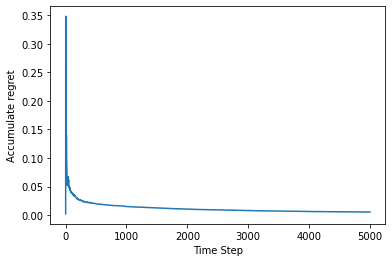

In [59]:
#为了证明regret与t^(1/3)同阶，将累积平均regrets除以t^(1/3)
regrets = (np.square(real_Y - np.array(Predict_Ys)).cumsum()/ np.array([t+1 for t in range(T)]))/np.power(np.array([t+1 for t in range(T)]),1/3)

plt.plot([t+1 for t in range(T)],regrets)

plt.xlabel("Time Step")
plt.ylabel("Avg. regret.")
plt.show()

In [60]:
real_Y2 = VectorizeFun(H2)(real_X)

Predict_Y2s = SEW(T,real_X,real_Y2)

当前为时段500
当前预测值为2.2360394089950288e-05
当前真实值为0
当前误差为4.999872238578838e-10
当前为时段1000
当前预测值为0.999994593514644
当前真实值为0
当前误差为0.9999891870585181
当前为时段1500
当前预测值为1.0
当前真实值为0
当前误差为1.0
当前为时段2000
当前预测值为6.747492569379279e-22
当前真实值为0
当前误差为4.552865597382858e-43
当前为时段2500
当前预测值为0.9999983219566261
当前真实值为1
当前误差为2.815829564758574e-12
当前为时段3000
当前预测值为1.824255220548066e-31
当前真实值为0
当前误差为3.3279071096968727e-62
当前为时段3500
当前预测值为1.7402039567999675e-23
当前真实值为0
当前误差为3.028309811262263e-46
当前为时段4000
当前预测值为1.0
当前真实值为1
当前误差为0.0
当前为时段4500
当前预测值为1.0
当前真实值为0
当前误差为1.0
当前为时段5000
当前预测值为1.0
当前真实值为0
当前误差为1.0


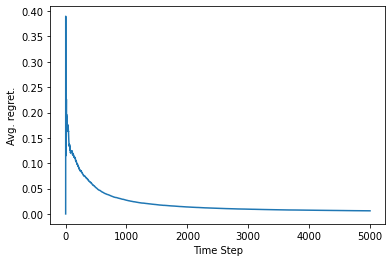

In [62]:
#为了证明regret与t^(1/3)同阶，将累积平均regrets除以t^(1/3)
regrets2 = (np.square(real_Y2 - np.array(Predict_Y2s)).cumsum()/ np.array([t+1 for t in range(T)]))/np.power(np.array([t+1 for t in range(T)]),1/3)

plt.plot([t+1 for t in range(T)],regrets2)

plt.xlabel("Time Step")
plt.ylabel("Avg. regret.")
plt.show()

In [61]:
real_Y3 = VectorizeFun(H3)(real_X)

Predict_Y3s = SEW(T,real_X,real_Y3)

当前为时段500
当前预测值为0.0036582132035446104
当前真实值为0.6666666666666666
当前误差为0.4395802093635608
当前为时段1000
当前预测值为0.011907302609054786
当前真实值为0.6666666666666666
当前误差为0.42870982482112824
当前为时段1500
当前预测值为0.007269815081694532
当前真实值为0.6666666666666666
当前误差为0.4348042078801737
当前为时段2000
当前预测值为2.3141434412120973e-10
当前真实值为0.0
当前误差为5.355259866504968e-20
当前为时段2500
当前预测值为0.9999992415015057
当前真实值为1.0
当前误差为5.753199659259143e-13
当前为时段3000
当前预测值为1.269353423516743e-13
当前真实值为0.0
当前误差为1.6112581137936758e-26
当前为时段3500
当前预测值为0.03262891252018972
当前真实值为0.6666666666666666
当前误差为0.4020038736831083
当前为时段4000
当前预测值为0.013683379151255014
当前真实值为0.3333333333333333
当前误差为0.10217609320860477
当前为时段4500
当前预测值为0.0441481038031403
当前真实值为0.6666666666666666
当前误差为0.38752936110967023
当前为时段5000
当前预测值为0.04436232998987573
当前真实值为0.6666666666666666
当前误差为0.3872626874467407


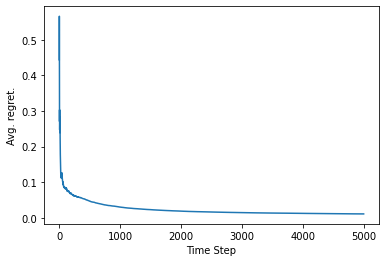

In [63]:
#为了证明regret与t^(1/3)同阶，将累积平均regrets除以t^(1/3)
regrets3 = (np.square(real_Y3 - np.array(Predict_Y3s)).cumsum()/ np.array([t+1 for t in range(T)]))/np.power(np.array([t+1 for t in range(T)]),1/3)

plt.plot([t+1 for t in range(T)],regrets3)

plt.xlabel("Time Step")
plt.ylabel("Avg. regret.")
plt.show()

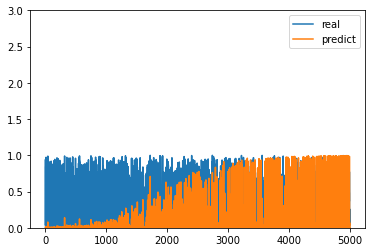

In [73]:
plt.plot([t+1 for t in range(T)],real_Y,label="real")
plt.plot([t+1 for t in range(T)],Predict_Ys,label="predict")
plt.ylim([0,3])
plt.legend()
plt.show()

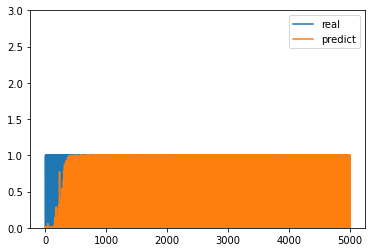

In [70]:
plt.plot([t+1 for t in range(T)],real_Y2,label="real")
plt.plot([t+1 for t in range(T)],Predict_Y2s,label="predict")
plt.ylim([0,3])
plt.legend()
plt.show()

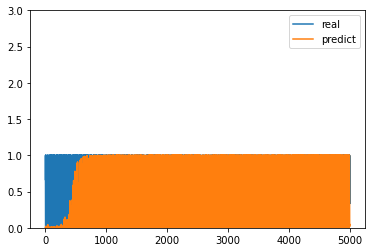

In [71]:
plt.plot([t+1 for t in range(T)],real_Y3,label="real")
plt.plot([t+1 for t in range(T)],Predict_Y3s,label="predict")
plt.ylim([0,3])
plt.legend()
plt.show()